### The goal of this model is to predict the traffic situation of a road based on a few predictors/features

### Importing required libray for data visualization and preprocessing

In [54]:
import numpy as np
import pandas as pd
import seaborn as sns
import  matplotlib.pyplot as plt

### Reading the csv file

In [55]:
traffic = pd.read_csv('Traffic.csv') 

### Data inspection

In [56]:
traffic.head()

,Time,Date,Day of the week,CarCount,BikeCount,BusCount,TruckCount,Total,Traffic Situation
0,12:00:00 AM,10,Tuesday,31,0,4,4,39,low
1,12:15:00 AM,10,Tuesday,49,0,3,3,55,low
2,12:30:00 AM,10,Tuesday,46,0,3,6,55,low
3,12:45:00 AM,10,Tuesday,51,0,2,5,58,low
4,1:00:00 AM,10,Tuesday,57,6,15,16,94,normal


In [57]:
traffic.tail()

,Time,Date,Day of the week,CarCount,BikeCount,BusCount,TruckCount,Total,Traffic Situation
2971,10:45:00 PM,9,Thursday,16,3,1,36,56,normal
2972,11:00:00 PM,9,Thursday,11,0,1,30,42,normal
2973,11:15:00 PM,9,Thursday,15,4,1,25,45,normal
2974,11:30:00 PM,9,Thursday,16,5,0,27,48,normal
2975,11:45:00 PM,9,Thursday,14,3,1,15,33,normal


### 3 categorical columns (time, day of the week, traffic situation)

In [58]:
traffic.describe()

,Date,CarCount,BikeCount,BusCount,TruckCount,Total
count,2976.000000,2976.000000,2976.000000,2976.000000,2976.000000,2976.000000
mean,16.000000,68.696573,14.917339,15.279570,15.324933,114.218414
std,8.945775,45.850693,12.847518,14.341986,10.603833,60.190627
min,1.000000,6.000000,0.000000,0.000000,0.000000,21.000000
25%,8.000000,19.000000,5.000000,1.000000,6.000000,55.000000
50%,16.000000,64.000000,12.000000,12.000000,14.000000,109.000000
75%,24.000000,107.000000,22.000000,25.000000,23.000000,164.000000
max,31.000000,180.000000,70.000000,50.000000,40.000000,279.000000


### from inspection, there are no missing values, but we have to cross check 

In [59]:
traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2976 entries, 0 to 2975
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Time               2976 non-null   object
 1   Date               2976 non-null   int64 
 2   Day of the week    2976 non-null   object
 3   CarCount           2976 non-null   int64 
 4   BikeCount          2976 non-null   int64 
 5   BusCount           2976 non-null   int64 
 6   TruckCount         2976 non-null   int64 
 7   Total              2976 non-null   int64 
 8   Traffic Situation  2976 non-null   object
dtypes: int64(6), object(3)
memory usage: 209.4+ KB


In [60]:
print(traffic.shape)

(2976, 9)


### Handling missing values

In [61]:
missing_values = traffic.isnull().sum()
print(missing_values)

Time                 0
Date                 0
Day of the week      0
CarCount             0
BikeCount            0
BusCount             0
TruckCount           0
Total                0
Traffic Situation    0
dtype: int64


## Handling Outliers

### Using Z-Score to treat the outliers

#### Identifying the outliers

In [62]:
for column in traffic.select_dtypes(include = ['int64' , 'float64']).columns:
    z_scores = (traffic[column] - traffic[column].mean())/ traffic[column].std()
    outliers = traffic[np.abs(z_scores)>3]

#### Handling the outliers - Standardization

In [63]:
# Function to impute outliers
def impute_outliers(traffic, method='median'):
    for column in traffic.select_dtypes(include=['int64', 'float64']).columns:
        # Calculate Z-scores
        z_scores = (traffic[column] - traffic[column].mean()) / traffic[column].std()
        # Identify outliers (Z-score > 3 or Z-score < -3)
        outliers = np.abs(z_scores) > 3
        # Calculate replacement value (mean or median)
        if method == 'mean':
            replacement_value = traffic[column].mean()
        elif method == 'median':
            replacement_value = traffic[column].median()
        else:
            raise ValueError("Method must be 'mean' or 'median'")
        # Impute outliers with the replacement value
        traffic.loc[outliers, column] = replacement_value
    return traffic
traffic_imputed = impute_outliers(traffic.copy(), method='median')
traffic = traffic_imputed
print(traffic)

             Time  Date Day of the week  CarCount  BikeCount  BusCount  \
0     12:00:00 AM    10         Tuesday        31          0         4   
1     12:15:00 AM    10         Tuesday        49          0         3   
2     12:30:00 AM    10         Tuesday        46          0         3   
3     12:45:00 AM    10         Tuesday        51          0         2   
4      1:00:00 AM    10         Tuesday        57          6        15   
...           ...   ...             ...       ...        ...       ...   
2971  10:45:00 PM     9        Thursday        16          3         1   
2972  11:00:00 PM     9        Thursday        11          0         1   
2973  11:15:00 PM     9        Thursday        15          4         1   
2974  11:30:00 PM     9        Thursday        16          5         0   
2975  11:45:00 PM     9        Thursday        14          3         1   

      TruckCount  Total Traffic Situation  
0              4     39               low  
1              3     55

### Using capping and flooring to check for outliers

In [64]:
for column in traffic.select_dtypes(include=['int64', 'float64']).columns:
    Q1 = traffic[column].quantile(0.25)
    Q3 = traffic[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    traffic[column] = np.where(traffic[column] > upper_bound, upper_bound, traffic[column])
    traffic[column] = np.where(traffic[column] < lower_bound, lower_bound, traffic[column])

### Visualization

array([[<Axes: title={'center': 'Date'}>,
        <Axes: title={'center': 'CarCount'}>],
       [<Axes: title={'center': 'BikeCount'}>,
        <Axes: title={'center': 'BusCount'}>],
       [<Axes: title={'center': 'TruckCount'}>,
        <Axes: title={'center': 'Total'}>]], dtype=object)

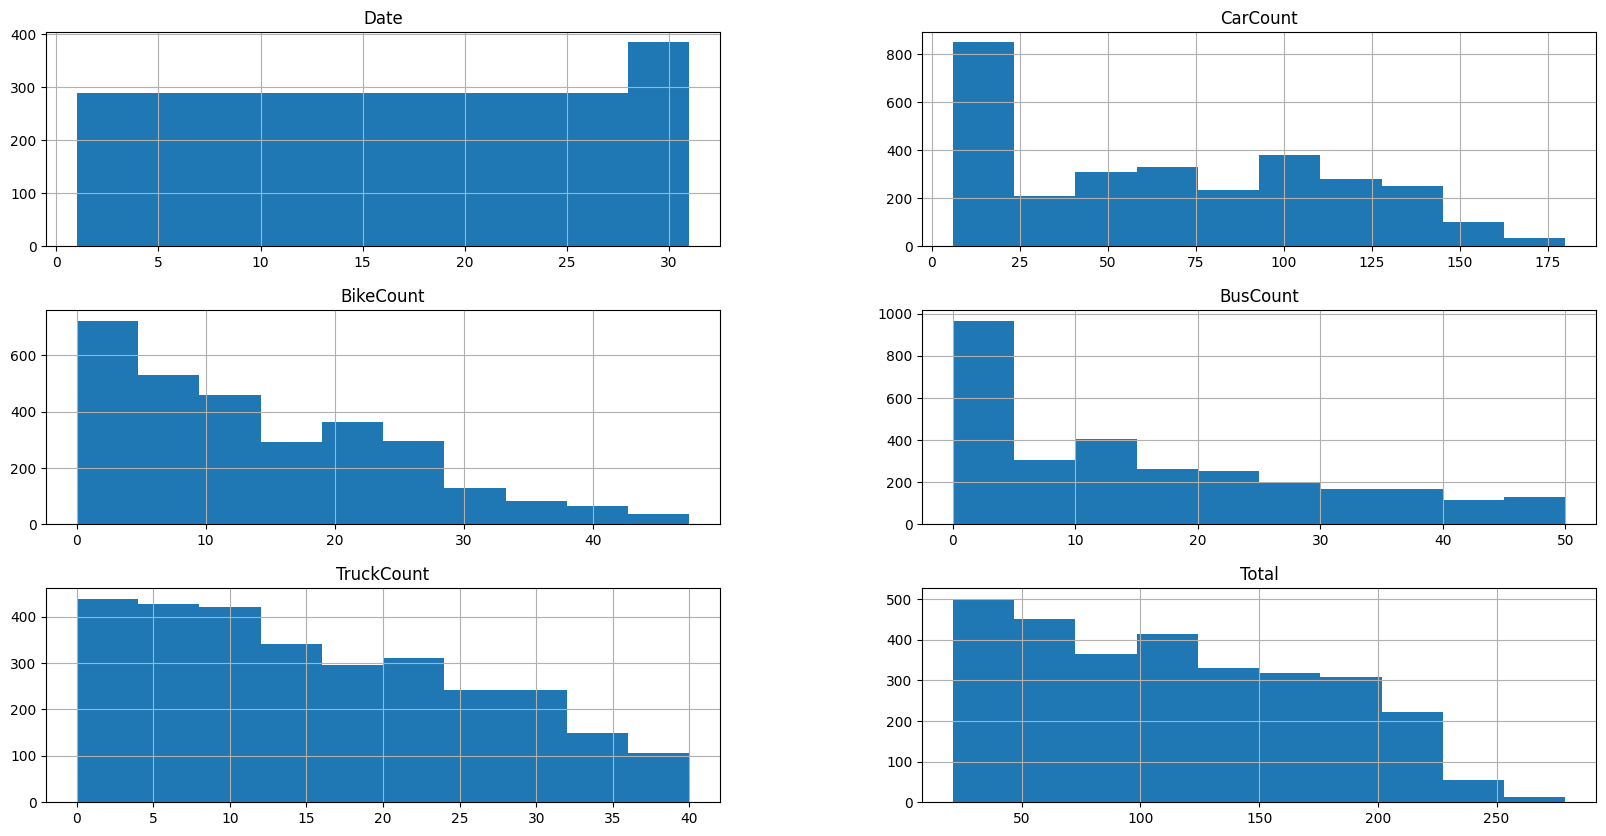

In [65]:
traffic.hist(figsize=(20, 10))

### Now let's handle the skewness

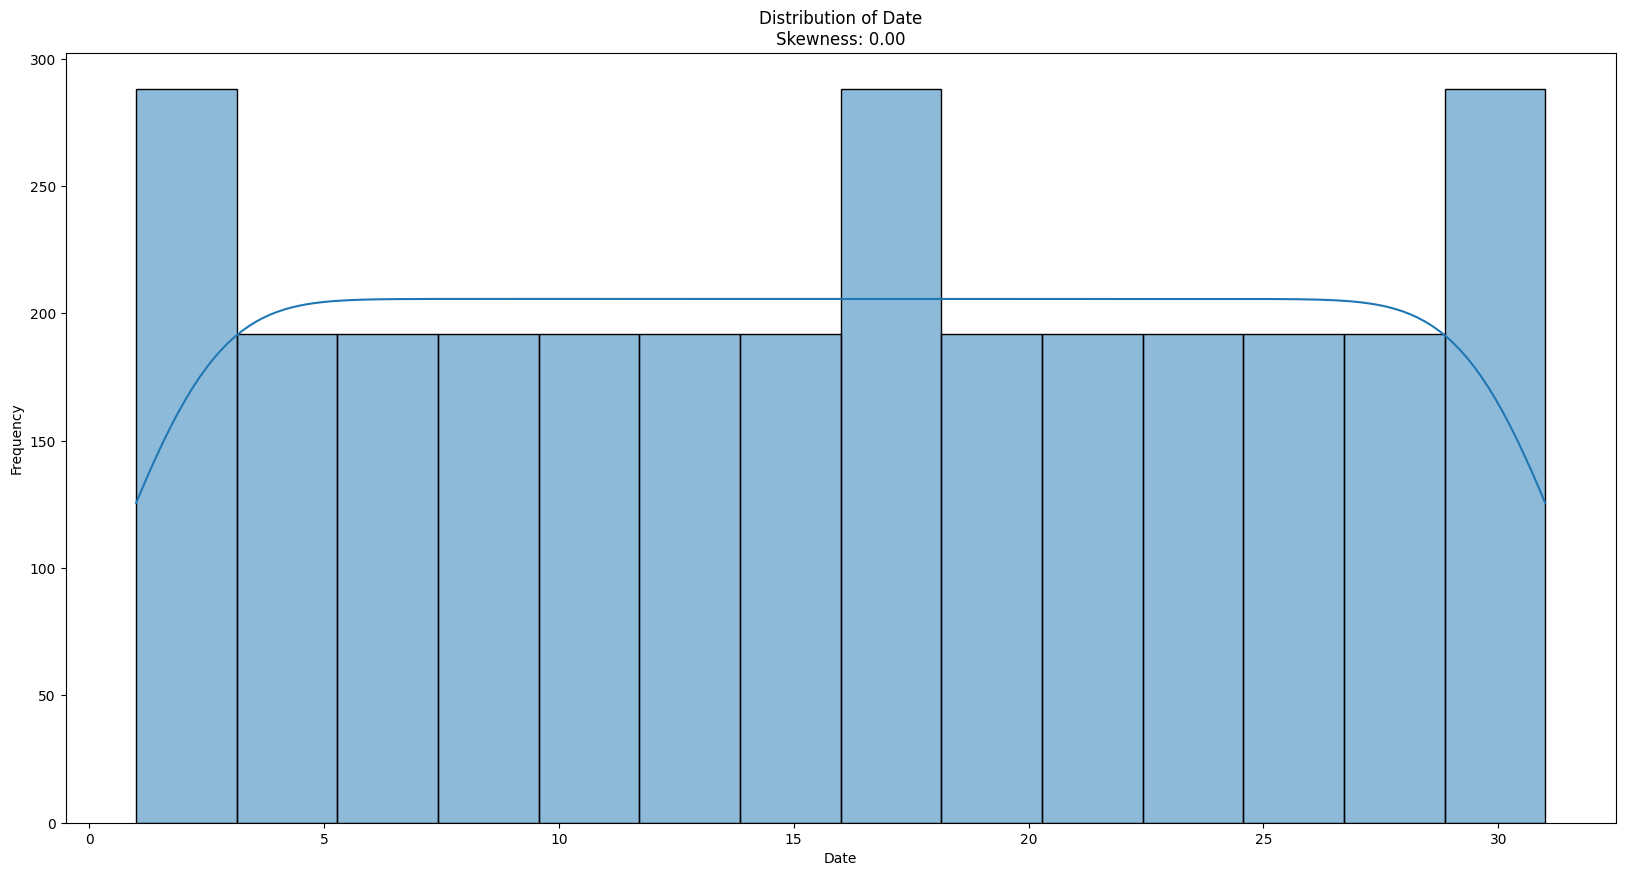

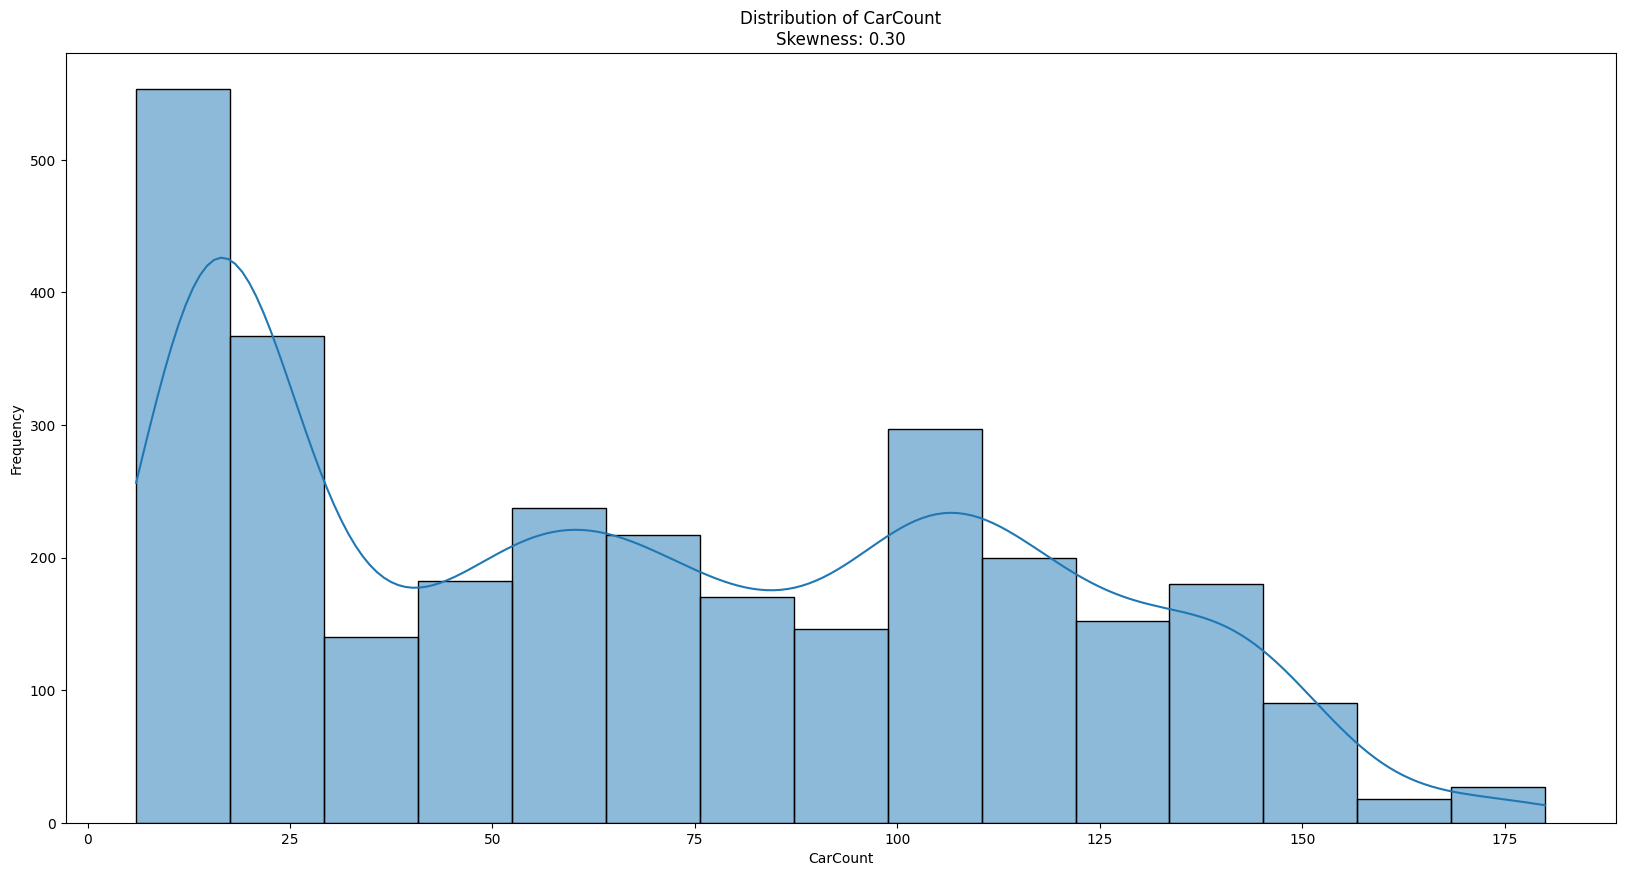

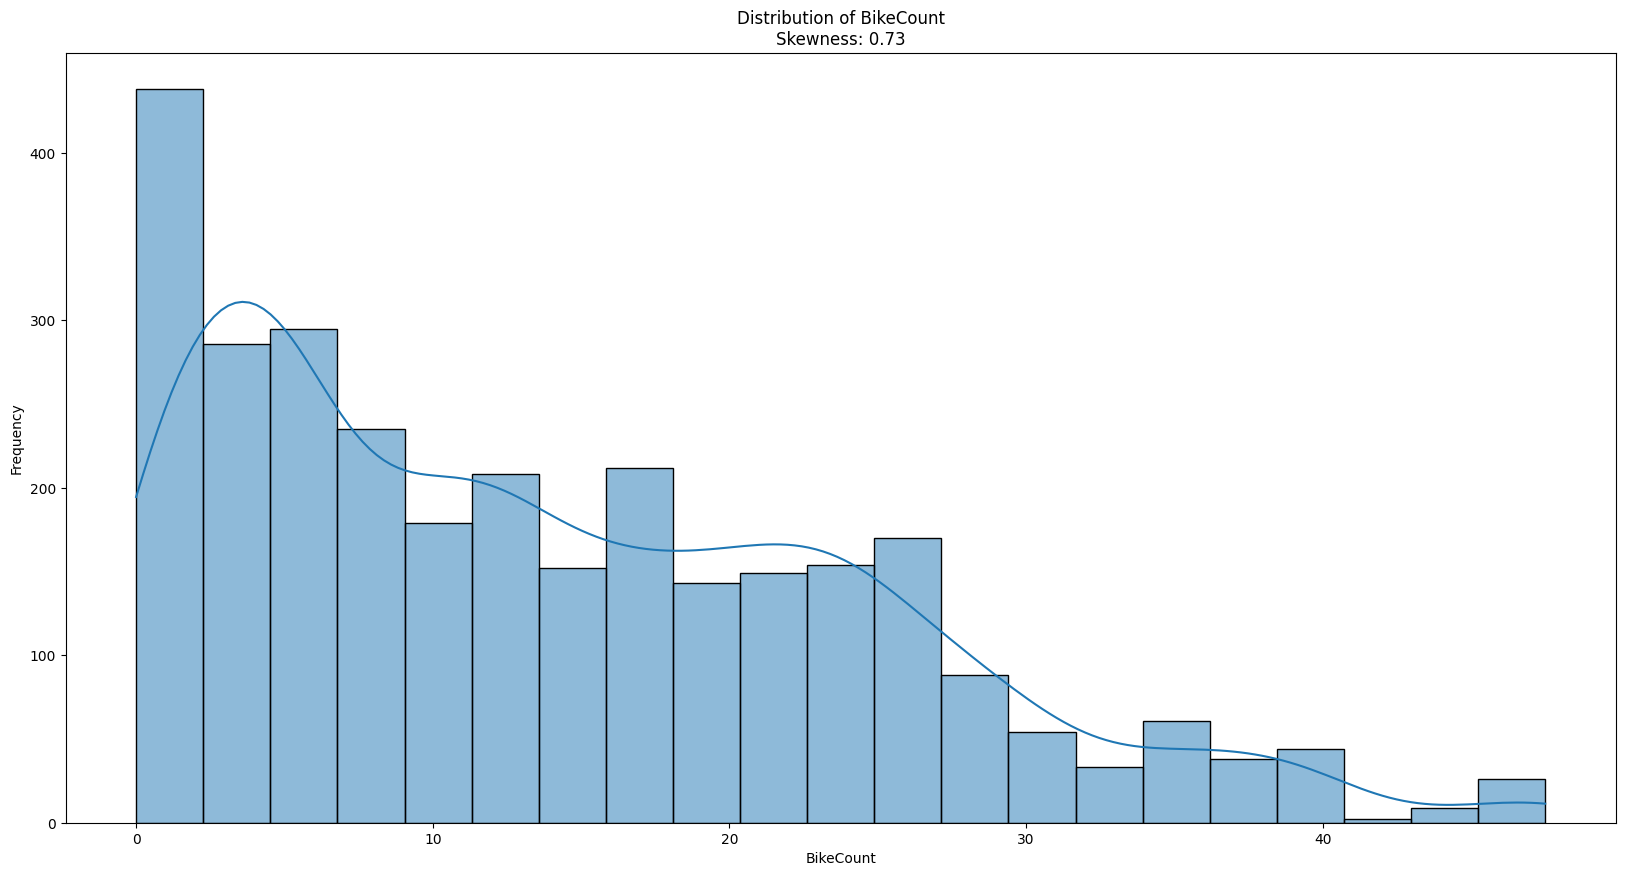

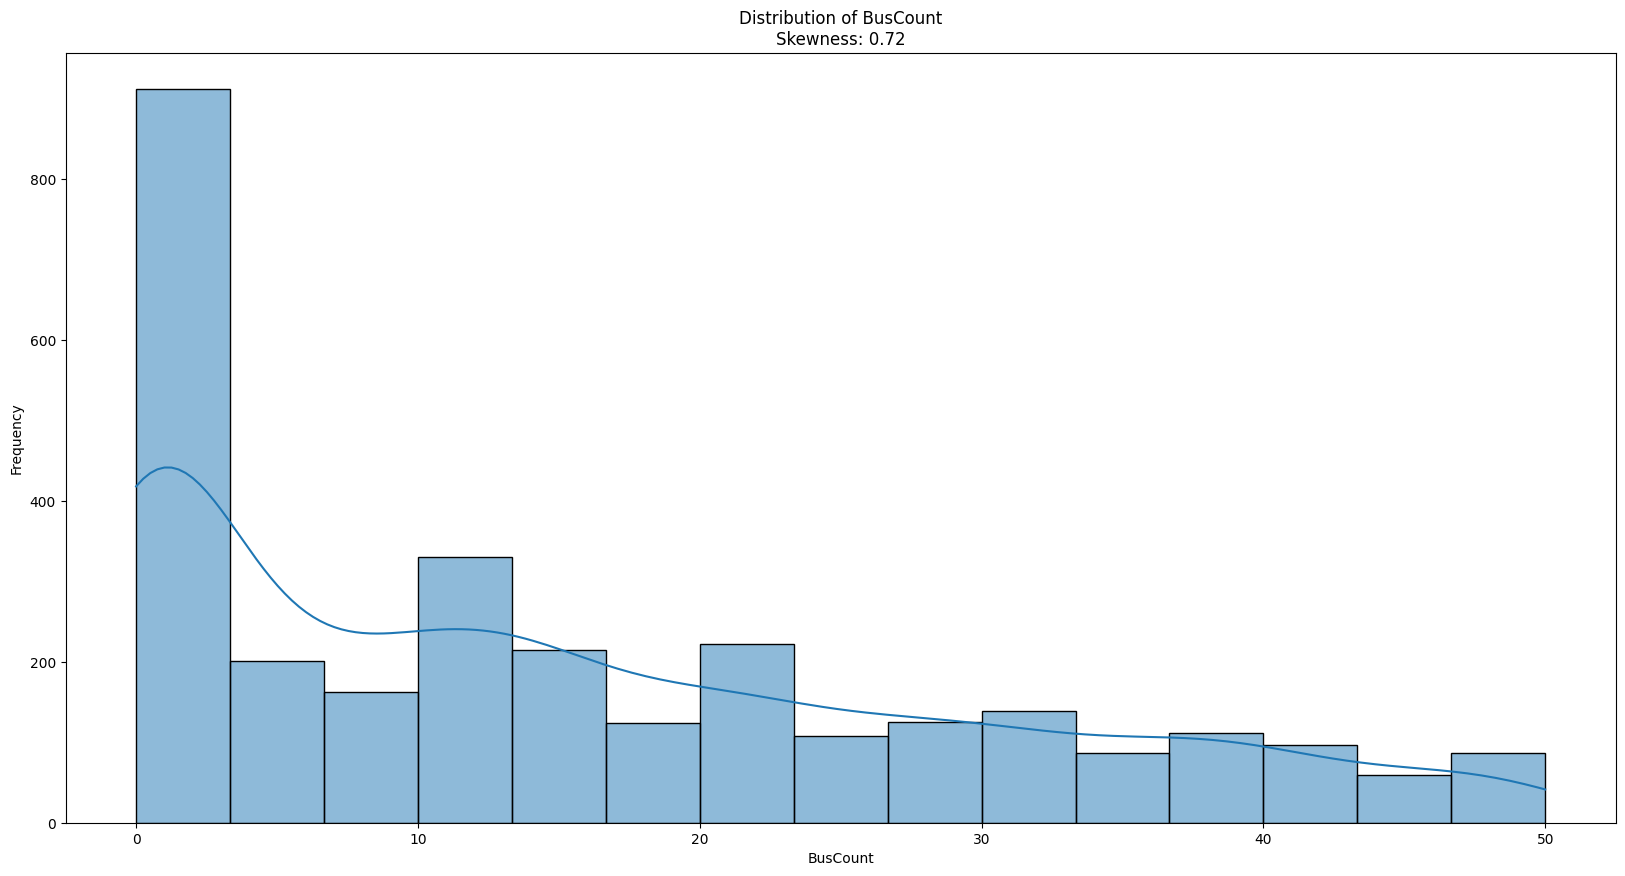

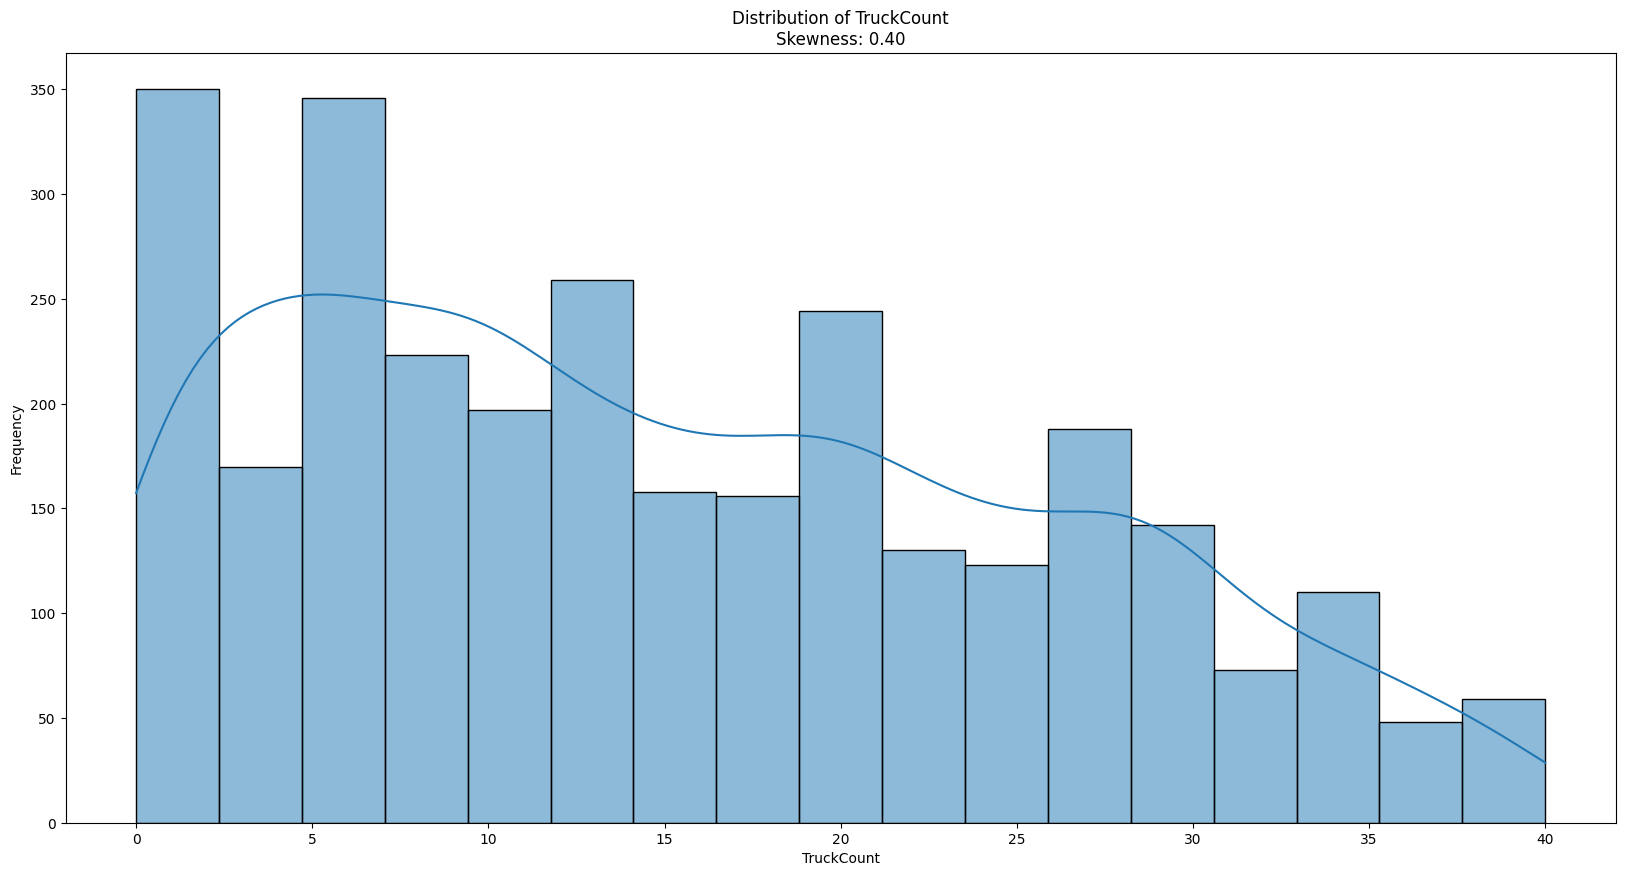

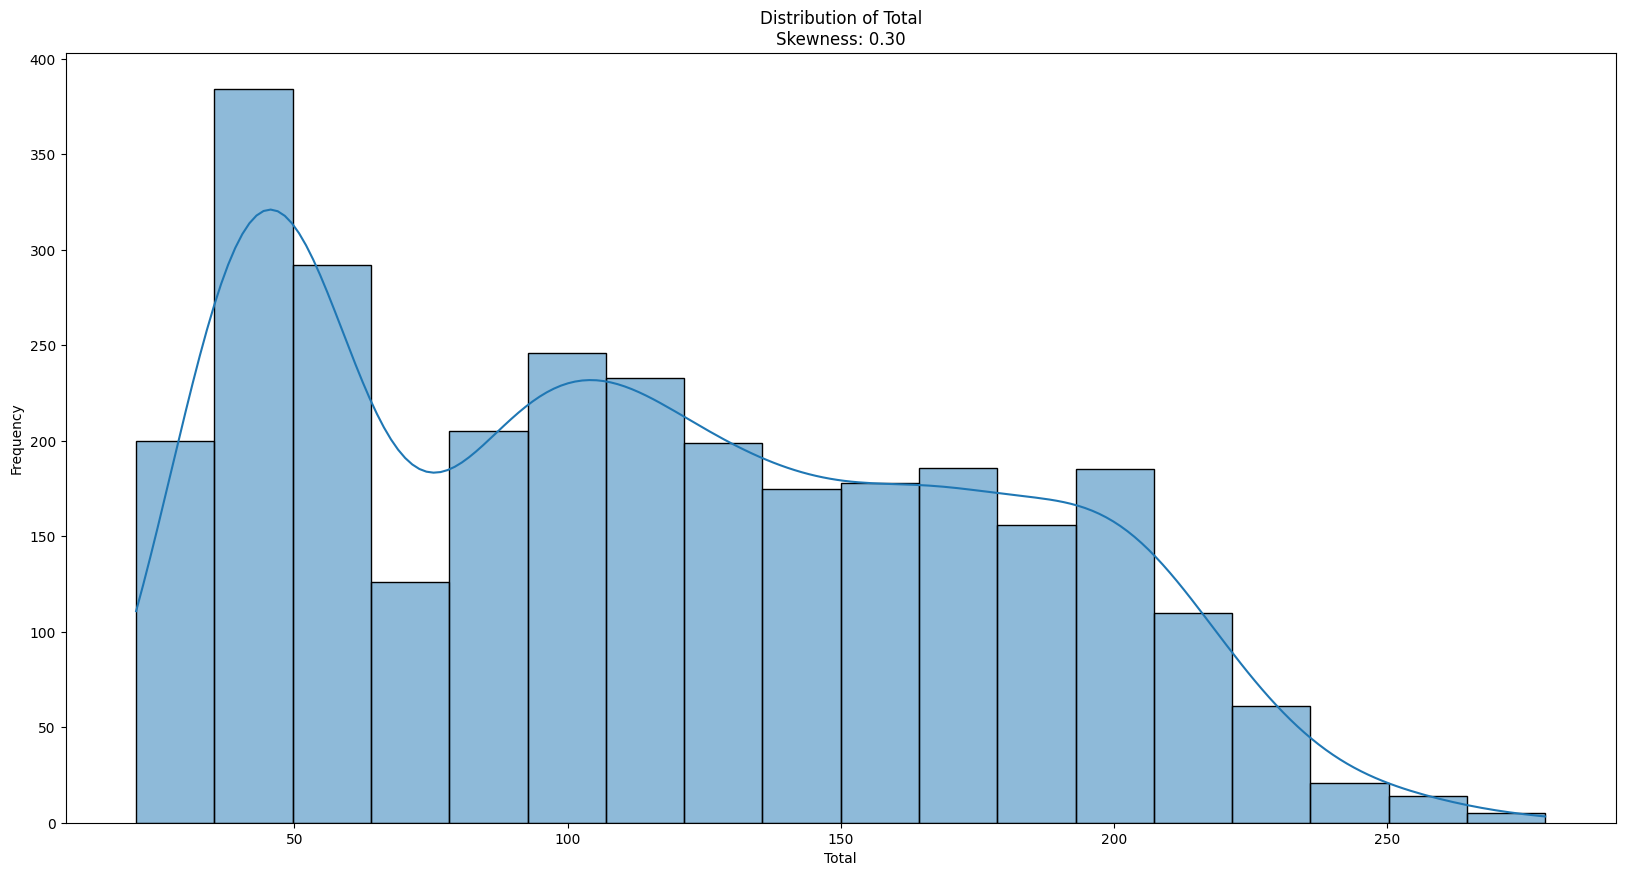

In [66]:
from scipy.stats import skew
for column in traffic.select_dtypes(include=['int64', 'float64']).columns:
    skewness = skew(traffic[column].dropna())  # Drop NaN values for skew calculation
    plt.figure(figsize=(20, 10))
    sns.histplot(traffic[column], kde=True)
    plt.title(f'Distribution of {column}\nSkewness: {skewness:.2f}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

In [67]:
# Apply log transformation to 'BusCount' and 'BikeCount' columns
traffic['BusCount_log'] = np.log(traffic['BusCount'] + 1)  # Add 1 to avoid log(0) if there are any zeros
traffic['BikeCount_log'] = np.log(traffic['BikeCount'] + 1)  # Same for BikeCount

# Check the skewness after transformation
print(traffic[['BusCount', 'BikeCount', 'BusCount_log', 'BikeCount_log']].skew())


BusCount         0.718089
BikeCount        0.731198
BusCount_log    -0.484837
BikeCount_log   -0.728787
dtype: float64


In [68]:
traffic['BikeCount_sqrt'] = np.sqrt(traffic['BikeCount'] + 1)
print(traffic['BikeCount_sqrt'].skew())


0.06995814378466604


### Heatmap and further visualization

In [69]:
traffic.head()

,Time,Date,Day of the week,CarCount,BikeCount,BusCount,TruckCount,Total,Traffic Situation,BusCount_log,BikeCount_log,BikeCount_sqrt
0,12:00:00 AM,10.0,Tuesday,31.0,0.0,4.0,4.0,39.0,low,1.609438,0.00000,1.000000
1,12:15:00 AM,10.0,Tuesday,49.0,0.0,3.0,3.0,55.0,low,1.386294,0.00000,1.000000
2,12:30:00 AM,10.0,Tuesday,46.0,0.0,3.0,6.0,55.0,low,1.386294,0.00000,1.000000
3,12:45:00 AM,10.0,Tuesday,51.0,0.0,2.0,5.0,58.0,low,1.098612,0.00000,1.000000
4,1:00:00 AM,10.0,Tuesday,57.0,6.0,15.0,16.0,94.0,normal,2.772589,1.94591,2.645751


In [70]:
# Columns to drop
columns_to_drop = ['Time', 'Date', 'BikeCount_log', 'BusCount_log', 'BikeCount_sqrt']
# Drop the columns from the DataFrame
traffic = traffic.drop(columns=columns_to_drop)
# Check the updated DataFrame
traffic.head()

,Day of the week,CarCount,BikeCount,BusCount,TruckCount,Total,Traffic Situation
0,Tuesday,31.0,0.0,4.0,4.0,39.0,low
1,Tuesday,49.0,0.0,3.0,3.0,55.0,low
2,Tuesday,46.0,0.0,3.0,6.0,55.0,low
3,Tuesday,51.0,0.0,2.0,5.0,58.0,low
4,Tuesday,57.0,6.0,15.0,16.0,94.0,normal


### Encoding: Traffic Situation - Ordinal Encoding

In [71]:
print(traffic['Traffic Situation'].unique())


['low' 'normal' 'heavy' 'high']


In [72]:
from sklearn.preprocessing import OrdinalEncoder

# Update the OrdinalEncoder with the correct categories
ordinal_encoder = OrdinalEncoder(categories=[['low', 'normal', 'heavy', 'high']])

# Apply ordinal encoding to the 'Traffic Situation' column
traffic['Traffic_Situation_encoded'] = ordinal_encoder.fit_transform(traffic[['Traffic Situation']])

# Display the encoded values
print(traffic[['Traffic Situation', 'Traffic_Situation_encoded']].head())


  Traffic Situation  Traffic_Situation_encoded
0               low                        0.0
1               low                        0.0
2               low                        0.0
3               low                        0.0
4            normal                        1.0


In [73]:
# Drop the original 'Traffic Situation' column
traffic = traffic.drop(columns=['Traffic Situation'])

# Display the updated DataFrame
print(traffic.head())


  Day of the week  CarCount  BikeCount  BusCount  TruckCount  Total  \
0         Tuesday      31.0        0.0       4.0         4.0   39.0   
1         Tuesday      49.0        0.0       3.0         3.0   55.0   
2         Tuesday      46.0        0.0       3.0         6.0   55.0   
3         Tuesday      51.0        0.0       2.0         5.0   58.0   
4         Tuesday      57.0        6.0      15.0        16.0   94.0   

   Traffic_Situation_encoded  
0                        0.0  
1                        0.0  
2                        0.0  
3                        0.0  
4                        1.0  


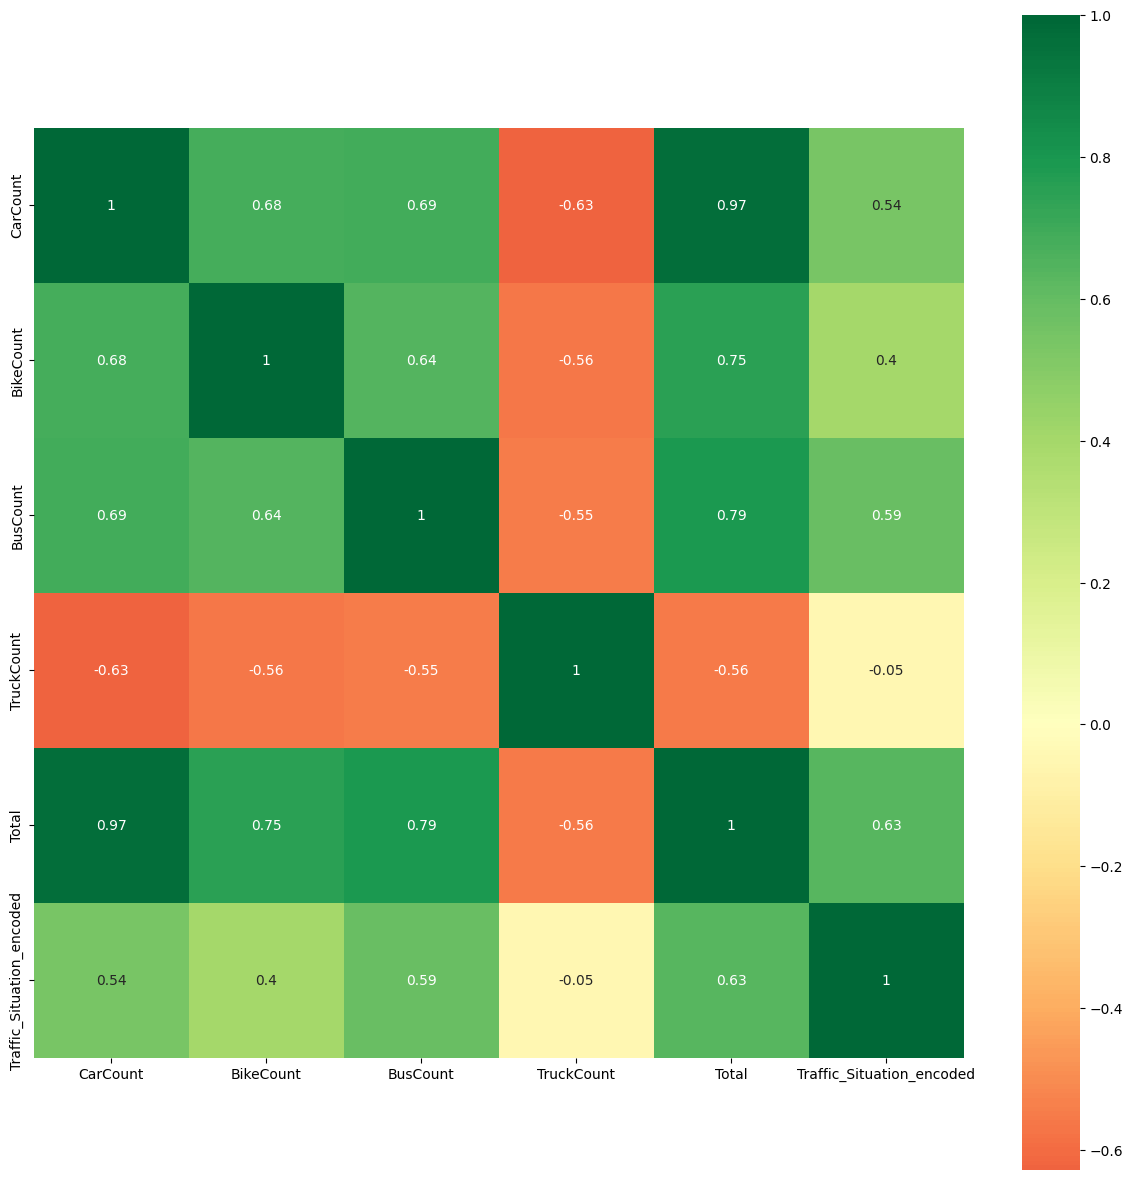

In [74]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

numeric_df = traffic.select_dtypes(include=['int64', 'float64'])

# Set figure size
plt.figure(figsize=(15, 15))

sns.heatmap(numeric_df.corr(), annot=True, cmap='RdYlGn', center=0, square=True, annot_kws={"size": 10})

plt.show()

### Save cleaned Dataset (might be needed for training a new model without need for preprocessing - MLP)

In [75]:
traffic.to_csv("Cleaned_Traffic.csv", index = False)

### Model Training

### Spliting dataset

In [76]:
from sklearn.model_selection import train_test_split

X = traffic.drop('Traffic_Situation_encoded', axis=1)  #predictor
y = traffic['Traffic_Situation_encoded'] #target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=89)

### Scaling the dataset

In [77]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
traffic_scaled = scaler.fit_transform(traffic[['CarCount', 'BikeCount', 'BusCount', 'TruckCount', 'Total']])
traffic[['CarCount_scaled', 'BikeCount_scaled', 'BusCount_scaled', 'TruckCount_scaled', 'Total_scaled']] = traffic_scaled
traffic_scaled = traffic

### Random Forest Classifier

In [83]:
from sklearn.ensemble import RandomForestClassifier
# Initialize and train the Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train_scaled, y_train)
# Predictions
y_pred = rf_classifier.predict(X_test_scaled)
# Evaluation
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Random Forest Classifier Accuracy: {accuracy:.4f}")
print(f"Confusion Matrix:\n{conf_matrix}")


Random Forest Classifier Accuracy: 0.9933
Confusion Matrix:
[[ 66   0   0   0]
 [  0 336   2   2]
 [  0   0 127   0]
 [  0   0   0  63]]


### Support Vector Classifier

In [84]:
from sklearn.svm import SVC
# Initialize and train the Support Vector Classifier
svc_classifier = SVC(random_state=42)
svc_classifier.fit(X_train_scaled, y_train)
# Predictions
y_pred = svc_classifier.predict(X_test_scaled)
# Evaluation
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Support Vector Classifier Accuracy: {accuracy:.4f}")
print(f"Confusion Matrix:\n{conf_matrix}")


Support Vector Classifier Accuracy: 0.9312
Confusion Matrix:
[[ 60   6   0   0]
 [  8 319   8   5]
 [  0   0 126   1]
 [  0   8   5  50]]


### KNN

In [85]:
from sklearn.neighbors import KNeighborsClassifier
# Initialize and train K-Nearest Neighbors model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

# Predictions
y_pred = knn.predict(X_test_scaled)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"KNN Classifier Accuracy: {accuracy:.4f}")


KNN Classifier Accuracy: 0.9413


### MLP Classifier

In [92]:
from sklearn.neural_network import MLPClassifier
# Initialize and train MLP model
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000)
mlp_classifier.fit(X_train_scaled, y_train)

# Predictions
y_pred = mlp_classifier.predict(X_test_scaled)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"MLP Neural Network Accuracy: {accuracy:.4f}")


MLP Neural Network Accuracy: 0.9832
